In [1]:
import adagram
import gensim
import pandas as pd
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os
from collections import Counter
import numpy as np
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word]

    return words

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split() if word and word not in stops]
    words = [word for word in words if word]

    return words

In [3]:
# запустите если не установлен ворднет
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

В wordnet все организовано в синсеты - наборы синонимов. 

In [2]:
len(list(wn.all_synsets()))

117659

Из них существительных:

In [3]:
len(list(wn.all_synsets('n')))

82115

А глаголов:

In [4]:
len(list(wn.all_synsets('v')))

13767

А прилагательных:

In [5]:
len(list(wn.all_synsets('a')))

18156

Синсет для слова можно достать вот так:

In [6]:
wn.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

Можно ограничить часть речи:

In [7]:
wn.synsets('go', pos='v')

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05'),
 Synset('run.v.05'),
 Synset('run.v.03'),
 Synset('proceed.v.04'),
 Synset('go.v.09'),
 Synset('go.v.10'),
 Synset('sound.v.02'),
 Synset('function.v.01'),
 Synset('run_low.v.01'),
 Synset('move.v.13'),
 Synset('survive.v.01'),
 Synset('go.v.16'),
 Synset('die.v.01'),
 Synset('belong.v.03'),
 Synset('go.v.19'),
 Synset('start.v.09'),
 Synset('move.v.15'),
 Synset('go.v.22'),
 Synset('go.v.23'),
 Synset('blend.v.02'),
 Synset('go.v.25'),
 Synset('fit.v.02'),
 Synset('rifle.v.02'),
 Synset('go.v.28'),
 Synset('plump.v.04'),
 Synset('fail.v.04')]

У многих из них есть определения:

In [8]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + synset.definition())
#     print()

day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)
day - an era of existence or influence
day - the period of time taken by a particular planet (e.g. Mars) to make a complete rotation on its axis
day - the time for one complete rotation of the earth relative to a particular star, about 4 minutes shorter than a mean solar day
day - a period of opportunity
day - United States writer best known for his autobiographical works (1874-1935)


И даже примеры:

In [9]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + ' | '.join(synset.examples()))
#     print()

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed
day - in the day of the dinosaurs | in the days of the Roman Empire | in the days of sailing ships | he was a successful pianist in his day
day - how long is a day on Jupiter?
day - 
day - he deserves his day in court | every dog has his day
day - 


Синсеты связаны между собой стандартными отношениями (гипонимии, антонимии, синонимии, меронимии).

In [10]:
s = wn.synsets('car')[0]

In [11]:
s.part_meronyms()

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01'),
 Synset('buffer.n.06'),
 Synset('bumper.n.02'),
 Synset('car_door.n.01'),
 Synset('car_mirror.n.01'),
 Synset('car_seat.n.01'),
 Synset('car_window.n.01'),
 Synset('fender.n.01'),
 Synset('first_gear.n.01'),
 Synset('floorboard.n.02'),
 Synset('gasoline_engine.n.01'),
 Synset('glove_compartment.n.01'),
 Synset('grille.n.02'),
 Synset('high_gear.n.01'),
 Synset('hood.n.09'),
 Synset('luggage_compartment.n.01'),
 Synset('rear_window.n.01'),
 Synset('reverse.n.02'),
 Synset('roof.n.02'),
 Synset('running_board.n.01'),
 Synset('stabilizer_bar.n.01'),
 Synset('sunroof.n.01'),
 Synset('tail_fin.n.02'),
 Synset('third_gear.n.01'),
 Synset('window.n.02')]

Антонимы только достаются не очень удобно:

In [12]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [13]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()
print(hyponyms)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


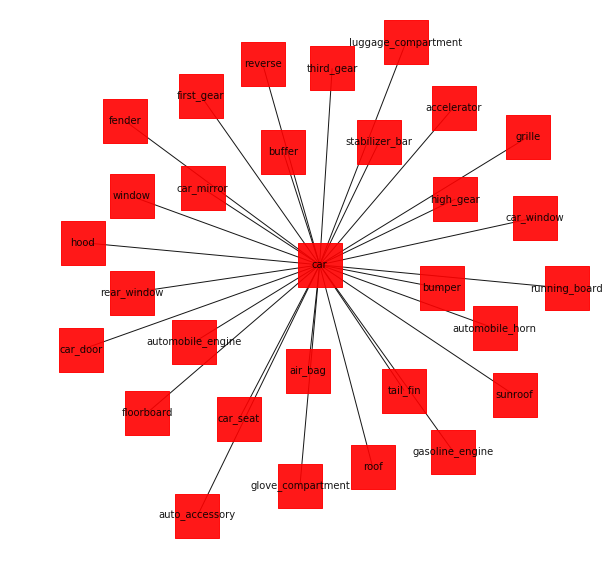

In [14]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')


Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [15]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]

In [16]:
bike.path_similarity(car)

0.3333333333333333

Есть и другие метрики:

In [17]:
wn.lch_similarity(bike, car)

2.538973871058276

In [18]:
wn.wup_similarity(bike, car)

0.9166666666666666

Ворднет можно использовать для дизамбигуации. Самый простой алгоритм - алгоритм Леска. Нужно посчитать пересечение слов контекста, в котором употреблено слово с разными определениями из ворднета. Значение с максимальным пересечением - нужное.

Давайте попробуем его реализовать.

### Задание 1. 
Напишите функцию, которая будет для каждого слова в списке доставать его контекст (3 слова слева, 3 слова справа).

In [19]:
# список из чисел, чтобы было удобно дебажить
words = [0,1,2,3,4,5,6,7,8,9]

def get_words_in_context(words, window=3):
    """Ваш код здесь """
    words_in_context = []
    for ind, word in enumerate(words):
        if ind <= 3:
            cont = words[:ind] + words[ind+1:ind+1+window]

        else:
            cont = words[ind-window:ind] + words[ind+1:ind+1+window]
            
        words_in_context.append(tuple([word, cont]))
    
    
    return words_in_context

In [20]:
get_words_in_context(words)

[(0, [1, 2, 3]),
 (1, [0, 2, 3, 4]),
 (2, [0, 1, 3, 4, 5]),
 (3, [0, 1, 2, 4, 5, 6]),
 (4, [1, 2, 3, 5, 6, 7]),
 (5, [2, 3, 4, 6, 7, 8]),
 (6, [3, 4, 5, 7, 8, 9]),
 (7, [4, 5, 6, 8, 9]),
 (8, [5, 6, 7, 9]),
 (9, [6, 7, 8])]

In [276]:
# работать должно вот так
get_words_in_context(words)

[(0, [1, 2, 3]),
 (1, [0, 2, 3, 4]),
 (2, [0, 1, 3, 4, 5]),
 (3, [0, 1, 2, 4, 5, 6]),
 (4, [1, 2, 3, 5, 6, 7]),
 (5, [2, 3, 4, 6, 7, 8]),
 (6, [3, 4, 5, 7, 8, 9]),
 (7, [4, 5, 6, 8, 9]),
 (8, [5, 6, 7, 9])]

### Задание 2. 
Теперь реализуйте сам алгоритм Леска

In [271]:
def lesk( word, sentence ):
    """Ваш код тут"""
    bestsense = 0
    maxoverlap = 0
    
    
    return bestsense


In [44]:
def lesk( word, sentence ):
    bestsense = 0
    maxoverlap = 0
    
    word=wn.morphy(word) if wn.morphy(word) is not None else word
    
    for sense in wn.synsets(word):
        overlap = overlapcontext(sense,sentence)
        for h in sense.hyponyms():
            overlap += overlapcontext( h, sentence )
        if overlap > maxoverlap:
                maxoverlap = overlap
                #bestsense = sense
                bestsense = int(sense.name().split('.')[2])
        #print(sense.name().split('.'))
    
    return bestsense

Теперь давайте возьмем какой-нибудь корпус, дизамбигуируем его и обучим на нем ворд2век.

In [30]:
functionwords = ['about', 'across', 'against', 'along', 'around', 'at',
                 'behind', 'beside', 'besides', 'by', 'despite', 'down',
                 'during', 'for', 'from', 'in', 'inside', 'into', 'near', 'of',
                 'off', 'on', 'onto', 'over', 'through', 'to', 'toward',
                 'with', 'within', 'without', 'anything', 'everything',
                 'anyone', 'everyone', 'ones', 'such', 'it', 'itself',
                 'something', 'nothing', 'someone', 'the', 'some', 'this',
                 'that', 'every', 'all', 'both', 'one', 'first', 'other',
                 'next', 'many', 'much', 'more', 'most', 'several', 'no', 'a',
                 'an', 'any', 'each', 'no', 'half', 'twice', 'two', 'second',
                 'another', 'last', 'few', 'little', 'less', 'least', 'own',
                 'and', 'but', 'after', 'when', 'as', 'because', 'if', 'what',
                 'where', 'which', 'how', 'than', 'or', 'so', 'before', 'since',
                 'while', 'although', 'though', 'who', 'whose', 'can', 'may',
                 'will', 'shall', 'could', 'be', 'do', 'have', 'might', 'would',
                 'should', 'must', 'here', 'there', 'now', 'then', 'always',
                 'never', 'sometimes', 'usually', 'often', 'therefore',
                 'however', 'besides', 'moreover', 'though', 'otherwise',
                 'else', 'instead', 'anyway', 'incidentally', 'meanwhile']

In [25]:
corpus = [tokenize(line) for line in open('corpus_eng.txt')]

In [28]:
def overlapcontext( synset, sentence ):
    gloss = set(word_tokenize(synset.definition()))
    for i in synset.examples():
         gloss.union(i)
    gloss = gloss.difference( functionwords )
    if isinstance(sentence, str):
        sentence = set(sentence.split(" "))
    elif isinstance(sentence, list):
        sentence = set(sentence)
    elif isinstance(sentence, set):
        pass
    else:
        return
    sentence = sentence.difference( functionwords )
    return len( gloss.intersection(sentence) )


In [46]:
dis_corpus = []
# пройдем по корпусу
for text in corpus:
    dis_text = []
    words_in_context = get_words_in_context(text)
    # дизамбигуируем каждой слов
    for word, context in words_in_context:
        nsense = lesk(word, context)
        
        # если смысл не нулевой - добавим индекс смысла к токену
        #print(nsense)
        if nsense > 0:
            #print(word)
            #print(nsense)
            dis_text.append(word + '_' + str(nsense))
        else:
            dis_text.append(word)
    
    dis_corpus.append(dis_text)

In [48]:
dis_corpus[0]

['states',
 'to',
 'watch',
 'on',
 'election',
 'day_3',
 '11/7/2016',
 '6:00am',
 'trump',
 'and',
 'clinton',
 'will_3',
 'put_1',
 'their',
 'election',
 'strategies_1',
 'to',
 'the',
 'test',
 'on',
 'tuesday',
 "wsj's",
 'gerald',
 'f',
 'seib',
 'discusses',
 'which',
 'states',
 'to',
 'watch',
 'as',
 'the',
 'polls',
 'close',
 'and',
 'which',
 'states',
 'both',
 'candidates_1',
 'need',
 'to',
 'win',
 'in',
 'order',
 'to',
 'claim',
 'victory',
 'photo',
 'ap',
 'transcript']

In [212]:
w2v = gensim.models.Word2Vec(dis_tokens, size=200)

In [214]:
w2v.most_similar('car')

[('came_2', 0.9824948906898499),
 ('brick', 0.9817278385162354),
 ('death_6', 0.9790238738059998),
 ('marriage', 0.9783040285110474),
 ('hamstring', 0.9766966104507446),
 ('first_1', 0.9766589403152466),
 ('friendly_1', 0.9764219522476196),
 ('forced', 0.9753144383430481),
 ('resident_1', 0.9745519757270813),
 ('rescue', 0.974374532699585)]

Есть ещё ворднет для русского. С похожим интерфейсом.

In [51]:
from wiki_ru_wordnet import WikiWordnet
import re
ruwn = WikiWordnet()

In [73]:
s = wikiwordnet.get_synsets('машина')[1]

In [244]:
s = wikiwordnet.get_synsets('машина')

In [245]:
a = list(s[0].get_words())[1]

In [234]:
a.lemma()

'аппарат'

In [248]:
sw = (list(s[0].get_words())[0])

In [241]:
normalize(re.sub('[\{\}|~]+', ' ', sw.definition()))

'машина ru машина ru физ ru разг ru ускоритель семантика синонимы=ускоритель антоним гиперонимы=механизм устройство прибор гипонимы=синхроциклотрон фазотрон пример выдел машина с постоянный магнитный поль и электрический поль переменный частота в англоязычный литература принять называть синхроциклотрон а в советский фазотрон 25646 92081'

## Адаграм

Word2Vec и Fasttext каждому слову (или буквенному нграму) сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. А чтобы разделять значения нам понадобилось извращаться с Wordnetom.

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопостовлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова.

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

Обучается адаграм через командную строку.

Возьмем данные с прошлого семинара и сохраним их в один файл.

In [4]:
data_rt = pd.read_csv('news_texts.csv')
data_rt.dropna(inplace=True)
corpus = ' '.join(data_rt.content_norm)

In [6]:
data_rt.dropna(inplace=True)

In [7]:
corpus = ' '.join(data_rt.content_norm)

In [9]:
f = open('corpus.txt', 'w')
f.write(corpus)
f.close()

Обучим модель (обучается долго поэтому можете пропустить этот шаг)

In [11]:
!adagram-train corpus.txt out.pkl

[INFO] 2018-10-20 10:09:06,251 Building dictionary...
[INFO] 2018-10-20 10:16:23,412 Done! 23621 words.
[INFO] 2018-10-20 10:23:27,885 1.39% -8.2791 0.0247 1.1/2.0 0.15 kwords/sec
[INFO] 2018-10-20 10:23:33,166 2.77% -8.1646 0.0243 1.1/2.0 12.12 kwords/sec
[INFO] 2018-10-20 10:23:38,347 4.16% -8.0490 0.0240 1.1/3.0 12.35 kwords/sec
[INFO] 2018-10-20 10:23:43,390 5.54% -7.9348 0.0236 1.1/3.0 12.69 kwords/sec
[INFO] 2018-10-20 10:23:48,327 6.93% -7.8237 0.0233 1.2/3.0 12.96 kwords/sec
[INFO] 2018-10-20 10:23:53,121 8.31% -7.7163 0.0229 1.2/3.0 13.35 kwords/sec
[INFO] 2018-10-20 10:23:58,024 9.70% -7.6136 0.0226 1.2/4.0 13.05 kwords/sec
[INFO] 2018-10-20 10:24:02,745 11.09% -7.5165 0.0222 1.2/5.0 13.56 kwords/sec
[INFO] 2018-10-20 10:24:07,455 12.47% -7.4255 0.0219 1.3/5.0 13.59 kwords/sec
[INFO] 2018-10-20 10:24:12,169 13.86% -7.3406 0.0215 1.3/5.0 13.58 kwords/sec
[INFO] 2018-10-20 10:24:16,868 15.24% -7.2619 0.0212 1.3/5.0 13.62 kwords/sec
[INFO] 2018-10-20 10:24:21,660 16.63% -7.1891 

Обученная модель загружается вот так.

In [293]:
vm = adagram.VectorModel.load("out.pkl")

In [324]:
# модель обученная на большом корпусе (острожно 1.5 гб)
# !wget 'https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib'
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

Посмотрим на значения каких-нибудь слова.

In [325]:
vm.word_sense_probs('россия')

[(0, 0.3742526793769188),
 (1, 0.0038911961243227604),
 (2, 0.12779475724436828),
 (3, 0.05091649393159962),
 (4, 0.30564585208630146),
 (5, 0.13749894459152373)]

Посмотрим какие слова близки к каждому из значений.

In [301]:
vm.sense_neighbors('россия', 0)

[('путин', 0, 0.6206749),
 ('владимир', 0, 0.5603346),
 ('вятрович', 0, 0.51075894),
 ('президент', 0, 0.5096558),
 ('подчеркнуть', 0, 0.5064843),
 ('оторвать', 0, 0.4924646),
 ('плотницкий', 0, 0.4688118),
 ('богатство', 0, 0.46369186),
 ('гройсмана', 0, 0.45962405),
 ('слово', 0, 0.4506323)]

In [302]:
vm.sense_neighbors('россия', 1)

[('сборная', 0, 0.6474809),
 ('мир', 0, 0.62199086),
 ('сборный', 0, 0.57577735),
 ('канада', 0, 0.57054496),
 ('словения', 0, 0.55525994),
 ('чемпионат', 0, 0.5550221),
 ('повести', 0, 0.5420381),
 ('хороший', 0, 0.5350354),
 ('один', 0, 0.52397877),
 ('поздравлять', 0, 0.52260417)]

In [303]:
vm.sense_neighbors('россия', 2)

[('вашингтон', 0, 0.55942065),
 ('опекунство', 0, 0.5465746),
 ('рф', 0, 0.5448662),
 ('опекун', 0, 0.54335696),
 ('экс-сотрудник', 0, 0.5410136),
 ('нереалистичный', 0, 0.5356396),
 ('официальный', 0, 0.53398347),
 ('гаубица', 0, 0.53221434),
 ('территория', 0, 0.53093505),
 ('ознакомление', 0, 0.52133447)]

Чтобы не гадать, можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [304]:
ambiguous = []
for word in vm.dictionary.id2word:
    probs = vm.word_sense_probs(word)
    if len(probs) > 1 and probs[0][0] < 0.8:
        ambiguous.append(word)

In [305]:
ambiguous

['год',
 'который',
 'это',
 'россия',
 'сша',
 'свой',
 'также',
 'один',
 'страна',
 'весь',
 'стать',
 'время',
 'заявить',
 'такой',
 'мочь',
 'отметить',
 'мир',
 '2017',
 'должный',
 'самый',
 'быть',
 'однако',
 'матч',
 'наш',
 'сторона',
 'дело',
 'решение',
 'игра',
 'эксперт',
 'считать',
 'другой',
 'сказать',
 'новый',
 'результат',
 'против',
 'получить',
 'место',
 'мнение',
 'международный',
 'дать',
 'победа',
 'иметь',
 'москва',
 'организация',
 'политика',
 'лидер',
 'смочь',
 'этот',
 'кроме',
 'сообщить',
 'национальный',
 'александр',
 'рассказать',
 'правительство',
 'подчеркнуть',
 'число',
 'программа',
 'провести',
 'идти',
 'the',
 'новость',
 'проект',
 'играть',
 'начало',
 'счёт',
 'владимир',
 'министр',
 'reuters',
 'участие',
 'итог',
 'удаться',
 'поддержка',
 'штат',
 'новое',
 'остаться',
 'знать',
 'первое',
 'сергей',
 'подобный',
 'группа',
 'необходимый',
 'помощь',
 'отмечать',
 'говориться',
 'назвать',
 '1',
 'экономический',
 'произойти',
 '

Как и с другими векторными моделями, проверять нужно на реальной задаче.

Возбмем определение перефразирования с прошлого семинара (и сравним сразу же)

In [306]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

Функцию, которая для текста делает векторное представление нужно немного переписать.

Что тут происходит?

In [312]:
def get_embedding_adagram(text, model, window, dim):
    text = text.split()
    
    
    word2context = []
    for i in range(len(text)-1):
        left = max(0, i-window)
        word = text[i]
        left_context = text[left:i]
        right_context = text[i+1:i+window]
        context = left_context + right_context
        word2context.append((word, context))
    
    
    
    vectors = np.zeros((len(word2context), dim))
    
    for i,word in enumerate(word2context):
        word, context = word
        try:
            sense = model.disambiguate(word, context).argmax()
            v = model.sense_vector(word, sense)
            vectors[i] = v # просто умножаем вектор на частоту
        
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [310]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

Сделаем все точно также как и на прошлом семинаре.

In [313]:
dim = 100
X_text_1 = np.zeros((len(data['text_1_norm']), dim))
X_text_2 = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1[i] = get_embedding_adagram(text, vm, 5, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2[i] = get_embedding_adagram(text, vm, 5, dim)

In [314]:
X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [315]:
y = data['label'].values

In [316]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y,random_state=1)
clf = RandomForestClassifier(n_estimators=200,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


              precision    recall  f1-score   support

          -1       0.60      0.51      0.55       629
           0       0.47      0.79      0.59       737
           1       0.59      0.06      0.11       441

   micro avg       0.51      0.51      0.51      1807
   macro avg       0.55      0.45      0.42      1807
weighted avg       0.55      0.51      0.46      1807



Сделаем ещё нормальную валидацию.

In [318]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1, class_weight='balanced',  multi_class='auto')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


              precision    recall  f1-score   support

          -1       0.45      0.47      0.46       629
           0       0.45      0.48      0.46       737
           1       0.30      0.24      0.27       441

   micro avg       0.42      0.42      0.42      1807
   macro avg       0.40      0.40      0.40      1807
weighted avg       0.41      0.42      0.41      1807



In [319]:
kf = KFold(n_splits=5)
f1_scores = []
for train_index, test_index in kf.split(X_text):
    
    X_train, X_test = X_text[train_index], X_text[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(n_estimators=200,
                             class_weight='balanced')
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    f1_scores.append(f1_score(y_test, preds, average='micro'))
    
print(np.mean(f1_scores))

0.4575923080972687


### WSD WSI

Адаграм создаваля как раз для того, чтобы находить и дизамбигуировать многозначные слова.

Посмотрим как он это делает на данных с соревнования Диалога - http://www.dialog-21.ru/evaluation/2018/disambiguation/

Возьмем один из наборов данных и запустим бейзлайновый скрипт на адаграме (тут используется большая адаграмовская модель и майстем)

In [320]:
import re
import sys
import adagram
from pymystem3 import Mystem
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score
import tqdm


mystem = Mystem()


def disambiguate(model, word, context):
    word, = lemmatized_context(word)
    probs = model.disambiguate(word, lemmatized_context(context))
    return 1 + probs.argmax()


def lemmatized_context(s):
    # This adagram model was trained with mystem lemmatizer, so better
    # use it here as well.
    return [w.lower() for w in mystem.lemmatize(s) if re.match('[\w\-]+$', w)]




In [321]:
df = pd.read_csv('train.csv', sep='\t')

In [322]:
df

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,дар,1,NaN,18-22,Отвергнуть щедрый дар
1,2,дар,1,NaN,21-28,покупать преданность дарами и наградами
2,3,дар,1,NaN,19-23,Вот яд – последний дар моей Изоры
3,4,дар,1,NaN,81-87,Основная функция корильных песен – повеселить ...
4,5,дар,1,NaN,151-157,Но недели две спустя (Алевтина его когда-то об...
5,6,дар,1,NaN,95-99,Мать Ревекки приберегала кусок и на праздник п...
6,7,дар,1,NaN,205-210,Время от времени Лидия Михайловна «доставала» ...
7,8,дар,1,NaN,80-84,Недавно приезжавший в Оргеев посол РФ в Молдав...
8,9,дар,2.1,NaN,18-22,Жизнь – бесценный дар
9,10,дар,2.1,NaN,25-29,Такая любовь – настоящий дар судьбы


In [326]:

df = pd.read_csv('train.csv', sep='\t')


df['predict_sense_id'] = [disambiguate(vm, word, context)
                          for word, context in tqdm.tqdm(zip(df['word'], df['context']), total=len(df))]

if df['gold_sense_id'].any():
    per_word = df.groupby('word').aggregate(
        lambda f: adjusted_rand_score(
            f['gold_sense_id'], f['predict_sense_id']))
    per_word_ari = per_word['predict_sense_id']
    
#     for word, ari in zip(per_word.index, per_word_ari):
#             print('{:<20} {:+.4f}'.format(word, ari))
    print('Mean word ARI: {:.4f}'.format(np.mean(per_word_ari)))





100%|██████████| 2073/2073 [00:02<00:00, 1013.86it/s]

Mean word ARI: 0.1789


В качестве метрики используется Adjuster Rand Index. https://en.wikipedia.org/wiki/Rand_index , http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

In [174]:
df = pd.read_csv('train.csv', sep='\t')

In [176]:
df.head(20)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,дар,1,NaN,18-22,Отвергнуть щедрый дар
1,2,дар,1,NaN,21-28,покупать преданность дарами и наградами
2,3,дар,1,NaN,19-23,Вот яд – последний дар моей Изоры
3,4,дар,1,NaN,81-87,Основная функция корильных песен – повеселить ...
4,5,дар,1,NaN,151-157,Но недели две спустя (Алевтина его когда-то об...
5,6,дар,1,NaN,95-99,Мать Ревекки приберегала кусок и на праздник п...
6,7,дар,1,NaN,205-210,Время от времени Лидия Михайловна «доставала» ...
7,8,дар,1,NaN,80-84,Недавно приезжавший в Оргеев посол РФ в Молдав...
8,9,дар,2.1,NaN,18-22,Жизнь – бесценный дар
9,10,дар,2.1,NaN,25-29,Такая любовь – настоящий дар судьбы


Попробуем решить эту задачу фастекстом.

Возьмем функцию для эмбединга предложений из прошлого семинара. (Вектора слов усредняются)

In [356]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [178]:
corpus = [text.split() for text in data_rt['content'].apply(tokenize)]
fast_text = gensim.models.FastText(corpus, size=200, max_vocab_size=100000)

Данные соревнования - не новостные тексты, поэтому можно обучить модель на чем-то другом. Тексты из википедии наверное подойдут.

In [357]:
%%time
# corpus = [tokenize(text).split() for text in open('sentences_100k_wiki.txt')]
# fast_text = gensim.models.FastText(corpus, size=200, max_vocab_size=100000)
fast_text = gensim.models.FastText.load('model_100k_wiki')

CPU times: user 536 ms, sys: 404 ms, total: 940 ms
Wall time: 1.21 s


С помощью функции groupby мы можем сделать словарь: слово, значения которого надо найти - всего его контексты и размеченные значения.

In [358]:
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [330]:

for key, _ in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

   word                                            context gold_sense_id
0   дар                              Отвергнуть щедрый дар             1
1   дар            покупать преданность дарами и наградами             1
2   дар                  Вот яд – последний дар моей Изоры             1
3   дар  Основная функция корильных песен – повеселить ...             1
4   дар  Но недели две спустя (Алевтина его когда-то об...             1
5   дар  Мать Ревекки приберегала кусок и на праздник п...             1
6   дар  Время от времени Лидия Михайловна «доставала» ...             1
7   дар  Недавно приезжавший в Оргеев посол РФ в Молдав...             1
8   дар                              Жизнь – бесценный дар           2.1
9   дар                Такая любовь – настоящий дар судьбы           2.1
10  дар                             Неисчислимы Божии дары           2.1
11  дар  Дар напрасный, дар случайный, / Жизнь, зачем т...           2.1
12  дар  Господа, – воскликнул я вдруг от всего сер

1670  закон  О законах акустики в древности знать не могли,...             4 


          word                                            context  \
1671  закрытие                     Автоматическое закрытие дверей   
1672  закрытие                                      закрытие люка   
1673  закрытие  У «Пежо» на водительской двери большую ручку с...   
1674  закрытие  Сегодня пятница, – продолжал торговец, – прибл...   
1675  закрытие                     Девять минут до закрытия люков   
1676  закрытие                                   Закрытие тоннеля   
1677  закрытие                    закрытие государственных границ   
1678  закрытие  Решение о закрытии съездов принято в связи с п...   
1679  закрытие  Министр внутренних дел России Степашин 26 апре...   
1680  закрытие                     Сидеть в ресторане до закрытия   
1681  закрытие                  Надо успеть в магазин до закрытия   
1682  закрытие  Кассы прекращают работать за сорок минут до за...   
1683  закрытие  Время б

По сути нам нужно кластеризовать контексты, в которых употреблено слово.

Попробуем разные методы кластеризации.

In [332]:
from sklearn.cluster import *

In [368]:
ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].apply(tokenize)
    X = np.zeros((len(texts), 200))
    
    for i, text in enumerate(texts):
        text = ' '.join([word for word in text.split(' ') if word != key])
        X[i] = get_embedding(text, fast_text, 200)
        
    cluster = AffinityPropagation(damping=0.9)
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1
    
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
#     print(key, '  ', adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
print(np.mean(ARI))

0.02556806730322881
